# Penalized Constrained Regression Demo

This notebook demonstrates the usage of the `penalized_constrained` package for fitting learning curve models with constraints and penalties.

## Setup and Imports

In [1]:
import penalized_constrained as pcreg
import numpy as np
import pandas as pd
import openpyxl
from sklearn.linear_model import LinearRegression

In [116]:
def create_lot_data(df, lc_slope, rc_slope, T1, cv_error=.1):
    """
    Calculate first unit, last unit, midpoint, and lot_size for production data.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a 'total' column containing lot quantities.
        Should be ordered by production sequence (e.g., by fiscal_year).
    lc_slope : float
        Learning curve slope (b parameter, typically negative, e.g., ln(0.9)/ln(2) ≈ -0.152).
    rc_slope : float
        Rate curve slope (c parameter, typically negative, e.g., ln(0.95)/ln(2) ≈ -0.074).
    T1 : float
        Theoretical first unit cost.

    Returns
    -------
    pd.DataFrame
        DataFrame with added columns:
        - first_unit: First unit number in the lot
        - last_unit: Last unit number in the lot  
        - lot_size: Quantity of units in the lot (same as 'total')
        - lot_midpoint: Asher's lot midpoint calculated using pcreg.calculate_lot_midpoint
        - cost: Predicted cost using learning curve model (T1 * midpoint^b * quantity^c)
    """
    df = df.copy()

    # Ensure total is numeric and use as lot_size
    df['total'] = pd.to_numeric(df['total'], errors='coerce')
    df = df.dropna(subset=['total']).reset_index(drop=True)
    df['lot_quantity'] = df['total']

    # Calculate cumulative units and first/last unit for each lot
    df['cumulative_units'] = df['lot_quantity'].cumsum()
    df['first_unit'] = df['cumulative_units'] - df['lot_quantity'] + 1
    df['last_unit'] = df['cumulative_units']
    

    # Calculate lot midpoint using Asher's formula from pcreg.utils
    df['lot_midpoint'] = df.apply(
        lambda row: pcreg.calculate_lot_midpoint(
            first_unit=row['first_unit'],
            last_unit=row['last_unit'],
            b=lc_slope
        ),
        axis=1
    )
    b = np.log(lc_slope)/np.log(2)
    c = np.log(rc_slope)/np.log(2)
    # Calculate cost using learning curve model: T1 * midpoint^b * quantity^c
    df['true_cost'] = T1 * (df['lot_midpoint'] ** b) * (df['lot_quantity'] ** c)
    df['observed_cost'] = df['true_cost'] * (1 + np.random.normal(0, cv_error, size=len(df))) 
    

    # Clean up temporary column
    df = df.drop(columns=['cumulative_units'])

    return df

In [ ]:
# Load and process SAR quantities data
# Note: Update the file path as needed for your environment

sar_quantities = (pd.read_csv('sar_raw_db/msar_annual_quantities.csv')
                .assign(fiscal_year=lambda df: pd.to_numeric(df.fiscal_year, errors='coerce'), 
                        total=lambda df: pd.to_numeric(df.total, errors='coerce'))
                .query('fiscal_year>0 and total.notna() and appn_account.str.lower().str.contains("procurement")')
                .groupby(['program','fiscal_year'], as_index=False)
                .agg({'total':'sum'})
                .sort_values(['program', 'fiscal_year'])
                # replace program name with generic program number to avoid confusion
                .assign(program=lambda df: df.groupby('program').ngroup()+1)
                .reset_index(drop=True)
                )

# Example: Apply create_lot_data to a single program
# Using 90% learning curve and 95% rate curve as examples
i=0 # Index for first program
lc_slope = .9  # ≈ -0.152
rc_slope = .95  # ≈ -0.074
T1 = 100  # Example first unit cost
n_lots = 10  # Number of lots to simulate
# Process first program in the dataset
first_program = sar_quantities.drop_duplicates(['program','appn_account']).reset_index().program[i]
first_appn = sar_quantities.drop_duplicates(['program','appn_account']).reset_index().appn_account[i]
program_data = sar_quantities[
(sar_quantities['program'] == first_program)
& (sar_quantities['appn_account'] == first_appn)
        ].copy().head(n_lots)

# Apply create_lot_data
lot_data = create_lot_data(program_data, lc_slope, rc_slope, T1)

print(np.corrcoef(lot_data['lot_midpoint'], lot_data['lot_quantity']))  # Correlation between observed and true cost
lot_data

[[1.        0.7629471]
 [0.7629471 1.       ]]


,program,appn_account,fiscal_year,total,lot_quantity,first_unit,last_unit,lot_midpoint,true_cost,observed_cost
0,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2010.0,8.0,8.0,1.0,8.0,4.433282,68.370154,70.316951
1,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2011.0,16.0,16.0,9.0,24.0,16.433472,53.223055,40.162933
2,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2012.0,27.0,27.0,25.0,51.0,37.918862,45.090740,50.094040
3,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2013.0,37.0,37.0,52.0,88.0,69.917845,40.139233,43.572543
4,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2014.0,35.0,35.0,89.0,123.0,105.951696,37.836887,35.734512
5,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2015.0,53.0,53.0,124.0,176.0,149.921690,34.806828,35.785659
6,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2016.0,64.0,64.0,177.0,240.0,208.417923,32.647981,27.771216
7,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2017.0,52.0,52.0,241.0,292.0,266.457677,31.938297,29.478344
8,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2018.0,48.0,48.0,293.0,340.0,316.469648,31.298892,36.522926
9,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",2019.0,48.0,48.0,341.0,388.0,364.473649,30.634161,27.097918


In [118]:
# Load and process SAR quantities data
# Note: Update the file path as needed for your environment

sar_quantities = (pd.read_csv('sar_raw_db/msar_annual_quantities.csv')
                .assign(fiscal_year=lambda df: pd.to_numeric(df.fiscal_year, errors='coerce'), 
                        total=lambda df: pd.to_numeric(df.total, errors='coerce'))
                .query('fiscal_year>0 and total.notna() and appn_account.str.lower().str.contains("procurement")')
                .groupby(['program','appn_account','fiscal_year'], as_index=False)
                .agg({'total':'sum'})
                .sort_values(['program', 'appn_account', 'fiscal_year'])
                .reset_index(drop=True)
                )

# Example: Apply create_lot_data to a single program
# Using 90% learning curve and 95% rate curve as examples
programs = sar_quantities.drop_duplicates(['program','appn_account']).reset_index()
results = []
for program in programs.itertuples():
    lc_slope = .9  # ≈ -0.152
    rc_slope = .95  # ≈ -0.074
    T1 = 100  # Example first unit cost
    n_lots = 10  # Number of lots to simulate
    # Process first program in the dataset
    first_program = program.program
    first_appn = program.appn_account
    program_data = sar_quantities[
    (sar_quantities['program'] == first_program)
    & (sar_quantities['appn_account'] == first_appn)
            ].copy().head(n_lots)

    # Apply create_lot_data
    lot_data = create_lot_data(program_data, lc_slope, rc_slope, T1)
    try:
        ols = LinearRegression()
        X,y = lot_data[['lot_midpoint', 'lot_quantity']],lot_data['observed_cost']
        ols.fit(np.log(X), np.log(y))
        t1 = np.exp(ols.intercept_)
        lc_slope = 2**ols.coef_[0]
        rc_slope=2**ols.coef_[1]
        score = ols.score(np.log(X), np.log(y))
        pc = pcreg.PCRegression(bounds={"T1": (0, None),"lc_slope":(.7,1), "rc_slope":(.7,1)},coef_names=["T1","lc_slope","rc_slope"], l1_ratio=0.0, alpha=0, prediction_fn=lc_func).fit(X, y)
        tmp = dict(program=first_program, appn_account=first_appn,t1 = np.exp(ols.intercept_),lc_slope = 2**ols.coef_[0], rc_slope=2**ols.coef_[1], score=score,pc=pc, pc_coef=pc.named_coef_)
        results.append(tmp)
    except Exception as e:
        print(e)
        pass
results_df = pd.DataFrame(results)
results_df

c:\Users\KevinJoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\KevinJoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\KevinJoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\KevinJoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\KevinJoy\AppData\Local\Programs

,program,appn_account,t1,lc_slope,rc_slope,score,pc,pc_coef
0,AH-64E Apache Remanufacture,"2031A - Aircraft Procurement, Army",57.903363,0.817844,1.193268,0.943873,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 86.04246193350396, 'lc_slope': 0.882949..."
1,AIM-9X Block II Sidewinder,"1507N - Weapons Procurement, Navy",117.002188,0.937424,0.882150,0.820144,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 118.96105757772557, 'lc_slope': 0.93513..."
2,AIM-9X Block II Sidewinder,"3020F - Missile Procurement, Air Force",75.263478,0.901055,0.985352,0.922506,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 74.37922275415441, 'lc_slope': 0.901382..."
3,AN/SPY-6(V)4 Subprogram,"1810N - Other Procurement, Navy",104.271888,0.904835,0.922654,0.906753,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 103.24435311054157, 'lc_slope': 0.90431..."
4,Advanced Anti-Radiation Guided Missile - Exten...,"1507N - Weapons Procurement, Navy",57.101052,0.819131,1.165034,0.961242,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 90.71389064971265, 'lc_slope': 0.876572..."
...,...,...,...,...,...,...,...,...
74,Unknown Program,"1810N - Other Procurement, Navy",88.838712,0.925606,0.967959,0.543622,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 90.36840366429678, 'lc_slope': 0.920999..."
75,Unknown Program,"2031A - Aircraft Procurement, Army",1209.146818,0.879784,0.700141,0.998805,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 1201.478254331088, 'lc_slope': 0.879946..."
76,Unknown Program,"2032A - Missile Procurement, Army",33.296763,1.000000,1.000000,NaN,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 33.29676957135392, 'lc_slope': 1.0, 'rc..."
77,Unknown Program,"2035A - Other Procurement, Army",24.012868,1.000000,1.000000,NaN,"PenalizedConstrainedRegression(alpha=0,\n ...","{'T1': 24.01287061215507, 'lc_slope': 1.0, 'rc..."


Model Type,PenalizedConstrainedRegression
Loss Function,sspe
Alpha,0
L1 Ratio,0.0
Fit Intercept,True
Scale,False
Bounds,"{'T1': (0, None), 'lc_slope': (0.7, 1), 'rc_slope': (0.7, 1)}"
Coefficient Names,"['T1', 'lc_slope', 'rc_slope']"
Method,SLSQP
Max Iterations,1000
Tolerance,1e-06

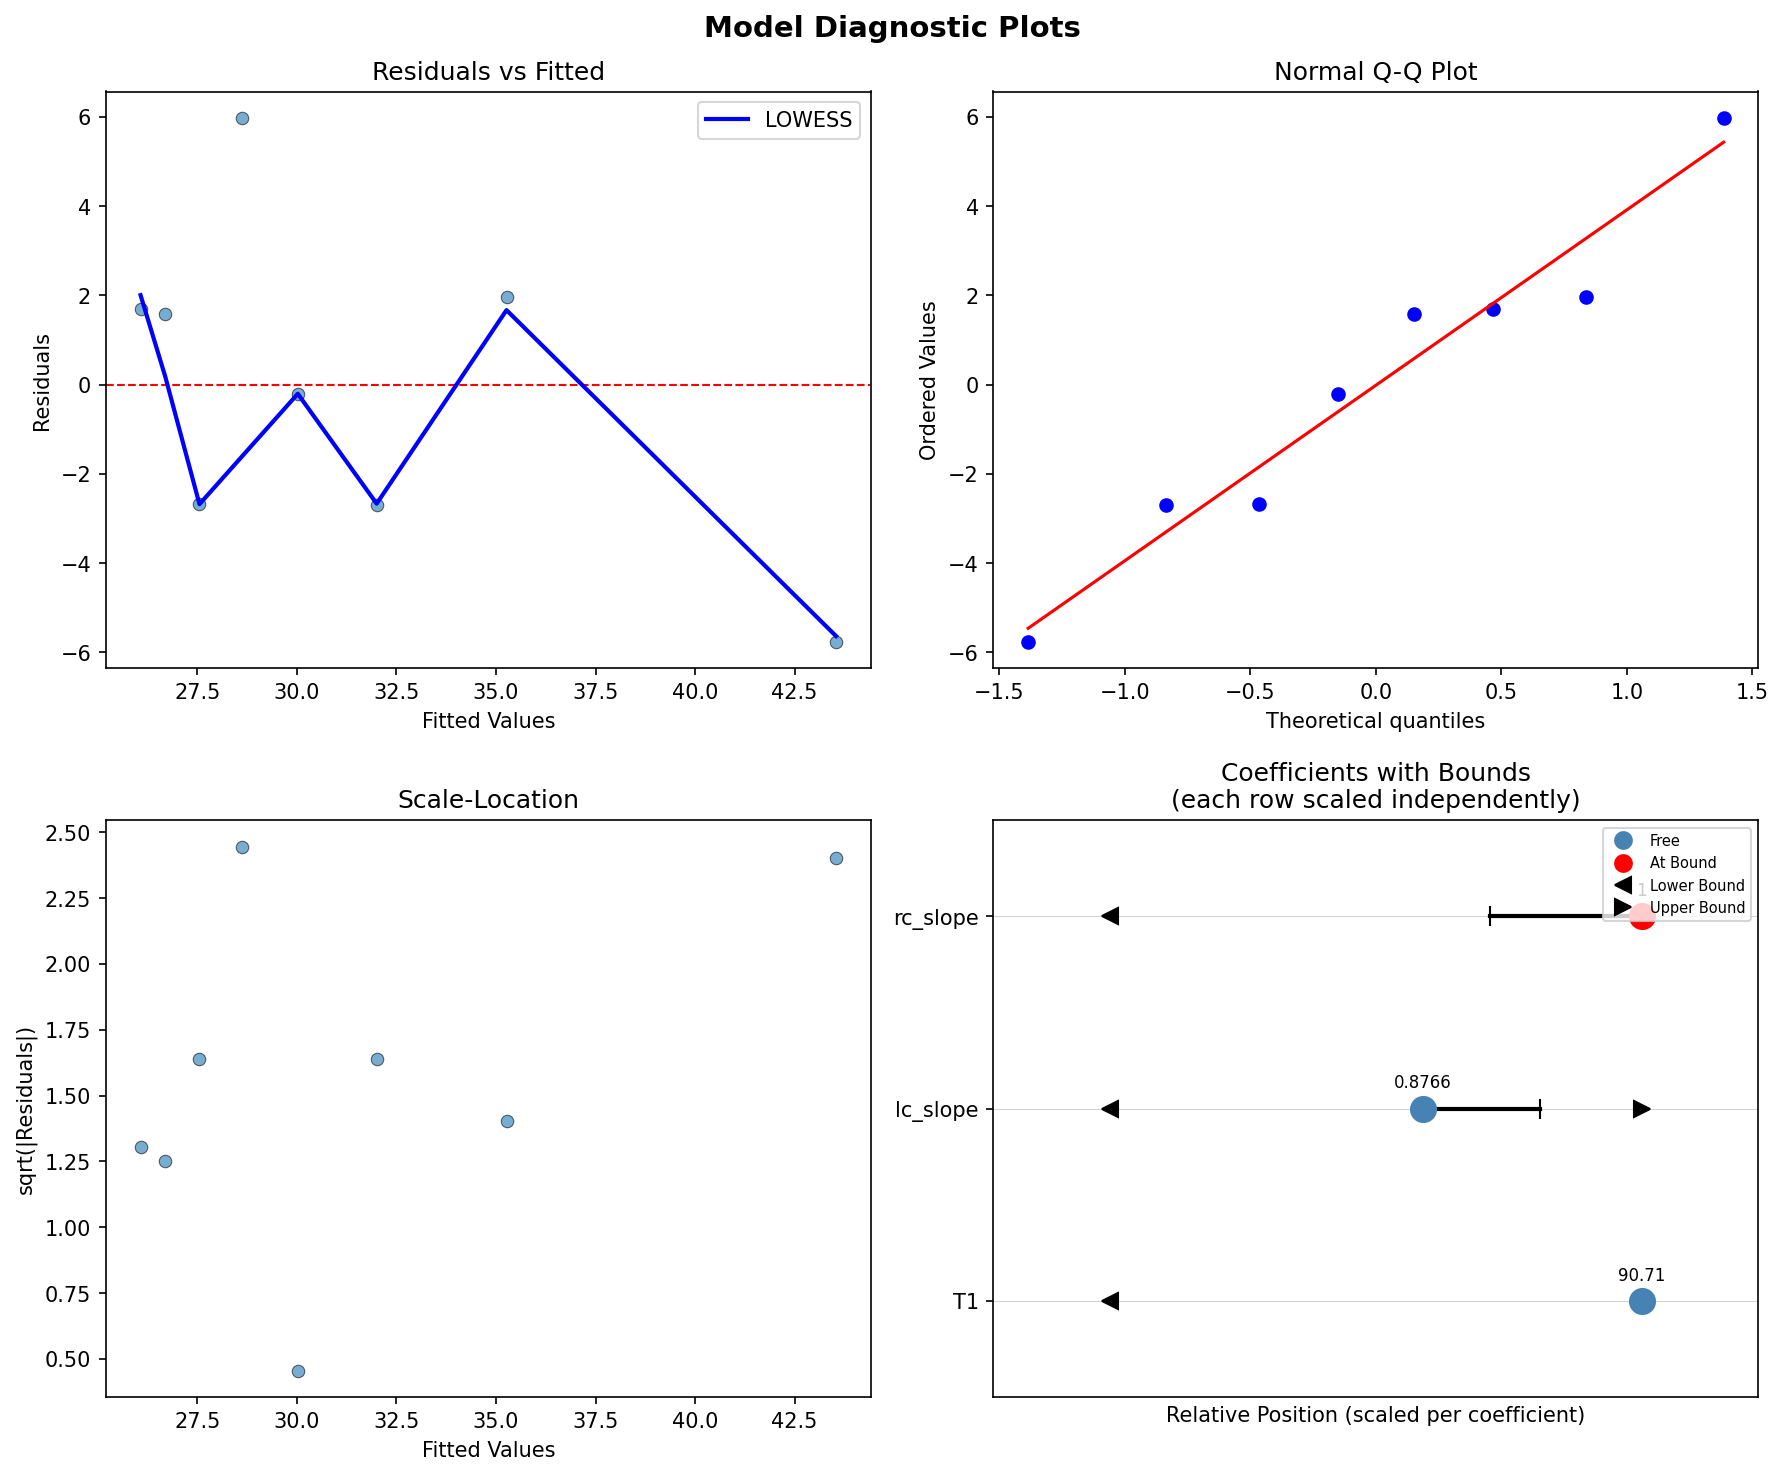

In [120]:
model_diagnostics = pcreg.ModelDiagnostics(results_df['pc'][4], lot_data[['lot_midpoint', 'lot_quantity']], lot_data['observed_cost'])
report = model_diagnostics.summary(bootstrap=True)
from IPython.display import HTML, display

# save report to variable using a file object
html_report = report.to_html()
# display report inline
display(HTML(html_report))

## Example: Load and Process SAR Data

Load SAR (Selected Acquisition Report) annual quantities data and calculate lot-level metrics.

## Helper Function: Create Lot Data

This function calculates first unit, last unit, midpoint, and lot_size for production data using Asher's lot midpoint formula.

## Generate Synthetic Learning Curve Data

We'll generate realistic learning curve data with correlated predictors and a specified level of error.

In [60]:
lot_data.plot(x='lot_midpoint', y='observed_cost', kind='scatter', title='Learning Curve Data', xlabel='Units Produced', ylabel='Lot Cost')

<Axes: title={'center': 'Learning Curve Data'}, xlabel='Units Produced', ylabel='Lot Cost'>

## Define Learning Curve Prediction Function

The learning curve follows the form: $T_1 \times \text{midpoint}^b \times \text{quantity}^c$ where:
- $T_1$ is the first unit cost
- $LC = 2^b$ is the learning curve percentage
- $RC = 2^c$ is the rate curve percentage

In [88]:
def lc_func(X, params):
    """Learning curve prediction function.

    X can be a DataFrame or numpy array with columns [lot_midpoint, lot_quantity]
    params are [T1, LC, RC] where LC/RC are learning/rate curve percentages
    """
    T1, LC, RC = params
    b = np.log(LC) / np.log(2)
    c = np.log(RC) / np.log(2)

    # Handle both DataFrame and numpy array input
    if hasattr(X, 'lot_midpoint'):
        midpoint = X.lot_midpoint.values
        quantity = X.lot_quantity.values
    else:
        midpoint = X[:, 0]
        quantity = X[:, 1]
    return T1 * (midpoint ** b) * (quantity ** c)

## Prepare Data for Modeling

Extract the predictor and response variables in both unit space and log space.

In [62]:
# Unit space data [midpoint, quantity]
X, y = lot_data[['lot_midpoint', 'lot_quantity']], lot_data['observed_cost']

# Log space data [midpoint, quantity]
X_log, y_log = np.log(X), np.log(y)

# True parameters from data generation
true_params = {
    'T1': T1,
    'b': np.log(lc_slope) / np.log(2),
    'c': np.log(rc_slope) / np.log(2)
}
print(f"True Parameters: T1={true_params['T1']}, LC={2**true_params['b']:.4f}, RC={2**true_params['c']:.4f}")

True Parameters: T1=100, LC=0.9000, RC=0.9500


## Fit Penalized Constrained Regression Model

Fit a model using cross-validation to select the optimal penalty parameters (alpha and l1_ratio).

Key features:
- Custom prediction function (non-linear learning curve)
- Named coefficients for interpretability
- Penalty exclusion for T1 parameter
- SSPE (Sum of Squared Percentage Errors) loss function

In [69]:
# Fit with named coefficients
model = pcreg.PenalizedConstrainedCV(
    coef_names=['T1', 'LC', 'RC'],
    bounds={'T1': (0,None), 'LC': (.7, 1), 'RC': (.7, 1)},
    #bounds=None,
    alphas=np.logspace(-4, .5, 10),
    l1_ratios=[0.0, 0.5, 1.0],
    loss='sspe',
    prediction_fn=lc_func,
    fit_intercept=False,
    penalty_exclude=['T1'],
    x0=[100, 0.99, 0.99]  # Starting point
)
model.fit(X, y)

print(f"PCReg Parameters: T1={model.named_coef_['T1']:.2f}, LC={model.named_coef_['LC']:.4f}, RC={model.named_coef_['RC']:.4f}")
print(f"Best alpha: {model.alpha_}, Best l1_ratio: {model.l1_ratio_}")

PCReg Parameters: T1=99.99, LC=0.8726, RC=1.0000
Best alpha: 0.0, Best l1_ratio: 0.0


## Fit OLS Model in Log Space (for comparison)

Fit a standard OLS regression in log space as a baseline comparison.

In [64]:
ols = LinearRegression()
ols.fit(X_log, y_log)
print(f"Sklearn OLS Parameters: T1={np.exp(ols.intercept_):.2f}, LC={2**ols.coef_[0]:.4f}, RC={2**ols.coef_[1]:.4f}")


Sklearn OLS Parameters: T1=99.61, LC=0.8730, RC=1.0012


Show that the penalized constrained regression without bounds and alpha=0 recovers the OLS solution.

In [65]:

ols_model = pcreg.PCRegression(
    coef_names=['b', 'r'],
    bounds={'b': (None,None), 'r': (None, None)},
    loss='mse',
    alpha=0.0,
    prediction_fn=None,  # OLS
    x0='ols',
    fit_intercept=True
)

ols_model.fit(X_log, y_log)

print(f"OLS Parameters: T1={np.exp(ols_model.intercept_):.2f}, LC={2**ols_model.named_coef_['b']:.4f}, RC={2**ols_model.named_coef_['r']:.4f}")

OLS Parameters: T1=99.61, LC=0.8730, RC=1.0012


In [66]:
print(
    np.isclose(ols.intercept_,ols_model.intercept_),
    np.isclose(ols.coef_[0], ols_model.coef_[0]),
    np.isclose(ols.coef_[1], ols_model.coef_[1])
)


True True True


## Compare Results

Compare the true parameters with both model estimates.

In [51]:
print(f"True Parameters:  T1={true_params['T1']}, LC={2**true_params['b']:.4f}, RC={2**true_params['c']:.4f}")
print(f"PCReg Parameters: T1={model.named_coef_['T1']:.2f}, LC={model.named_coef_['LC']:.4f}, RC={model.named_coef_['RC']:.4f}")
print(f"OLS Parameters:   T1={np.exp(ols_model.intercept_):.2f}, LC={2**ols_model.named_coef_['b']:.4f}, RC={2**ols_model.named_coef_['r']:.4f}")

True Parameters:  T1=100, LC=0.9000, RC=0.9500
PCReg Parameters: T1=100.00, LC=0.9051, RC=0.9421
OLS Parameters:   T1=108.94, LC=0.9080, RC=0.9243


## Generate Comprehensive Diagnostics for PCReg Model

Generate a comprehensive diagnostics report including:
- Bootstrap confidence intervals
- Residual plots
- Alpha trace plot
- Model fit statistics

In [52]:
diag = pcreg.ModelDiagnostics(model, X, y)
# Note: alpha_trace not supported for custom prediction_fn with different param count than X features
report = diag.summary(bootstrap=True, n_bootstrap=100, include_alpha_trace=True)
report_plots=report.plot_diagnostics()

Model Type,PenalizedConstrainedCV
Loss Function,sspe
Alpha,0.0
L1 Ratio,0.0
Fit Intercept,False
Scale,False
Coefficient Names,"['T1', 'LC', 'RC']"
Penalty Exclude,['T1']
Method,SLSQP
Max Iterations,1000
Tolerance,1e-06

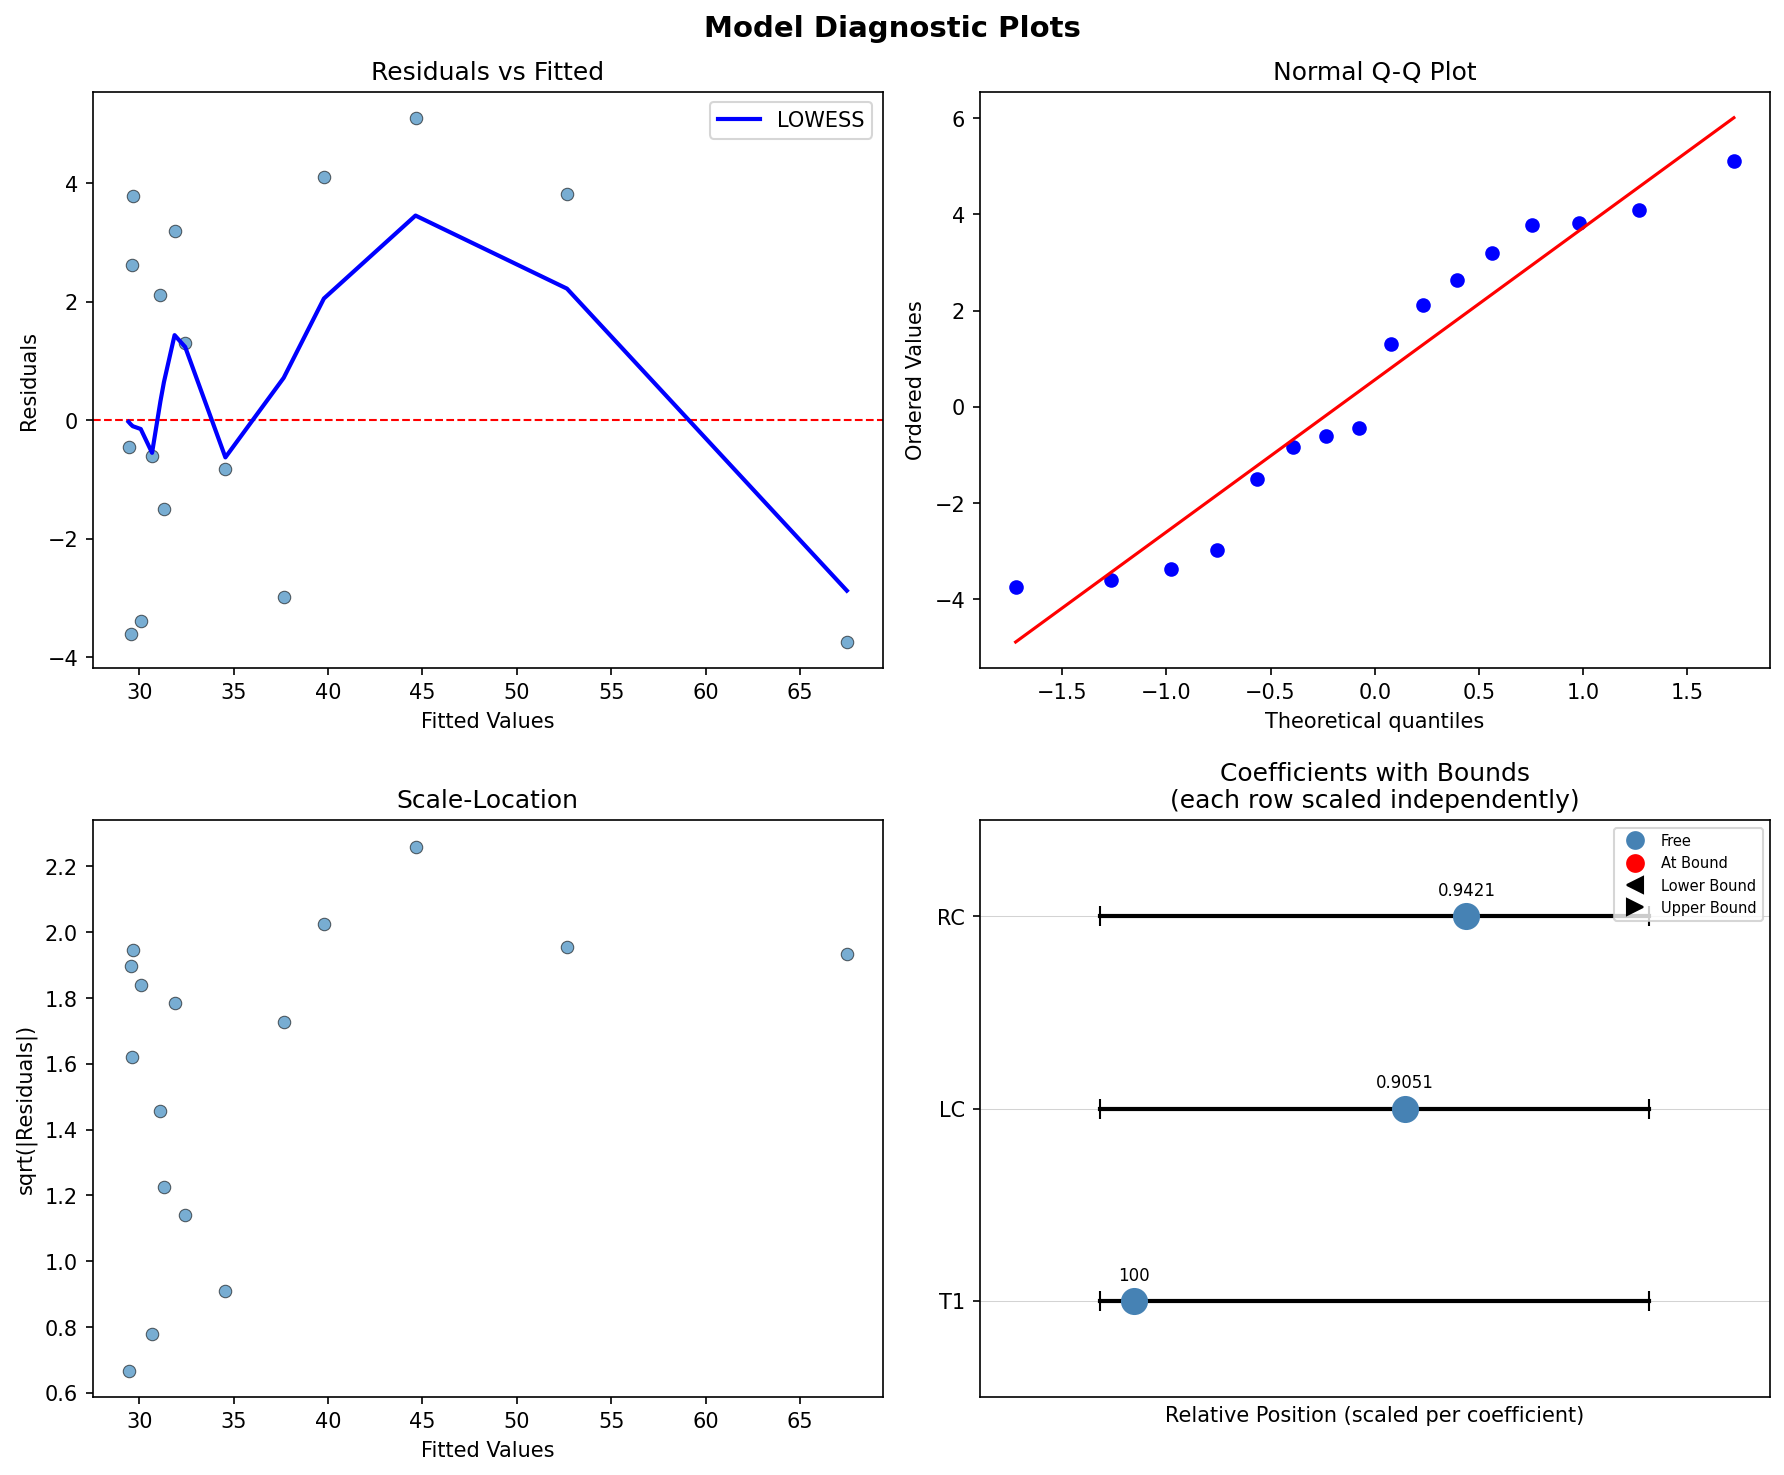
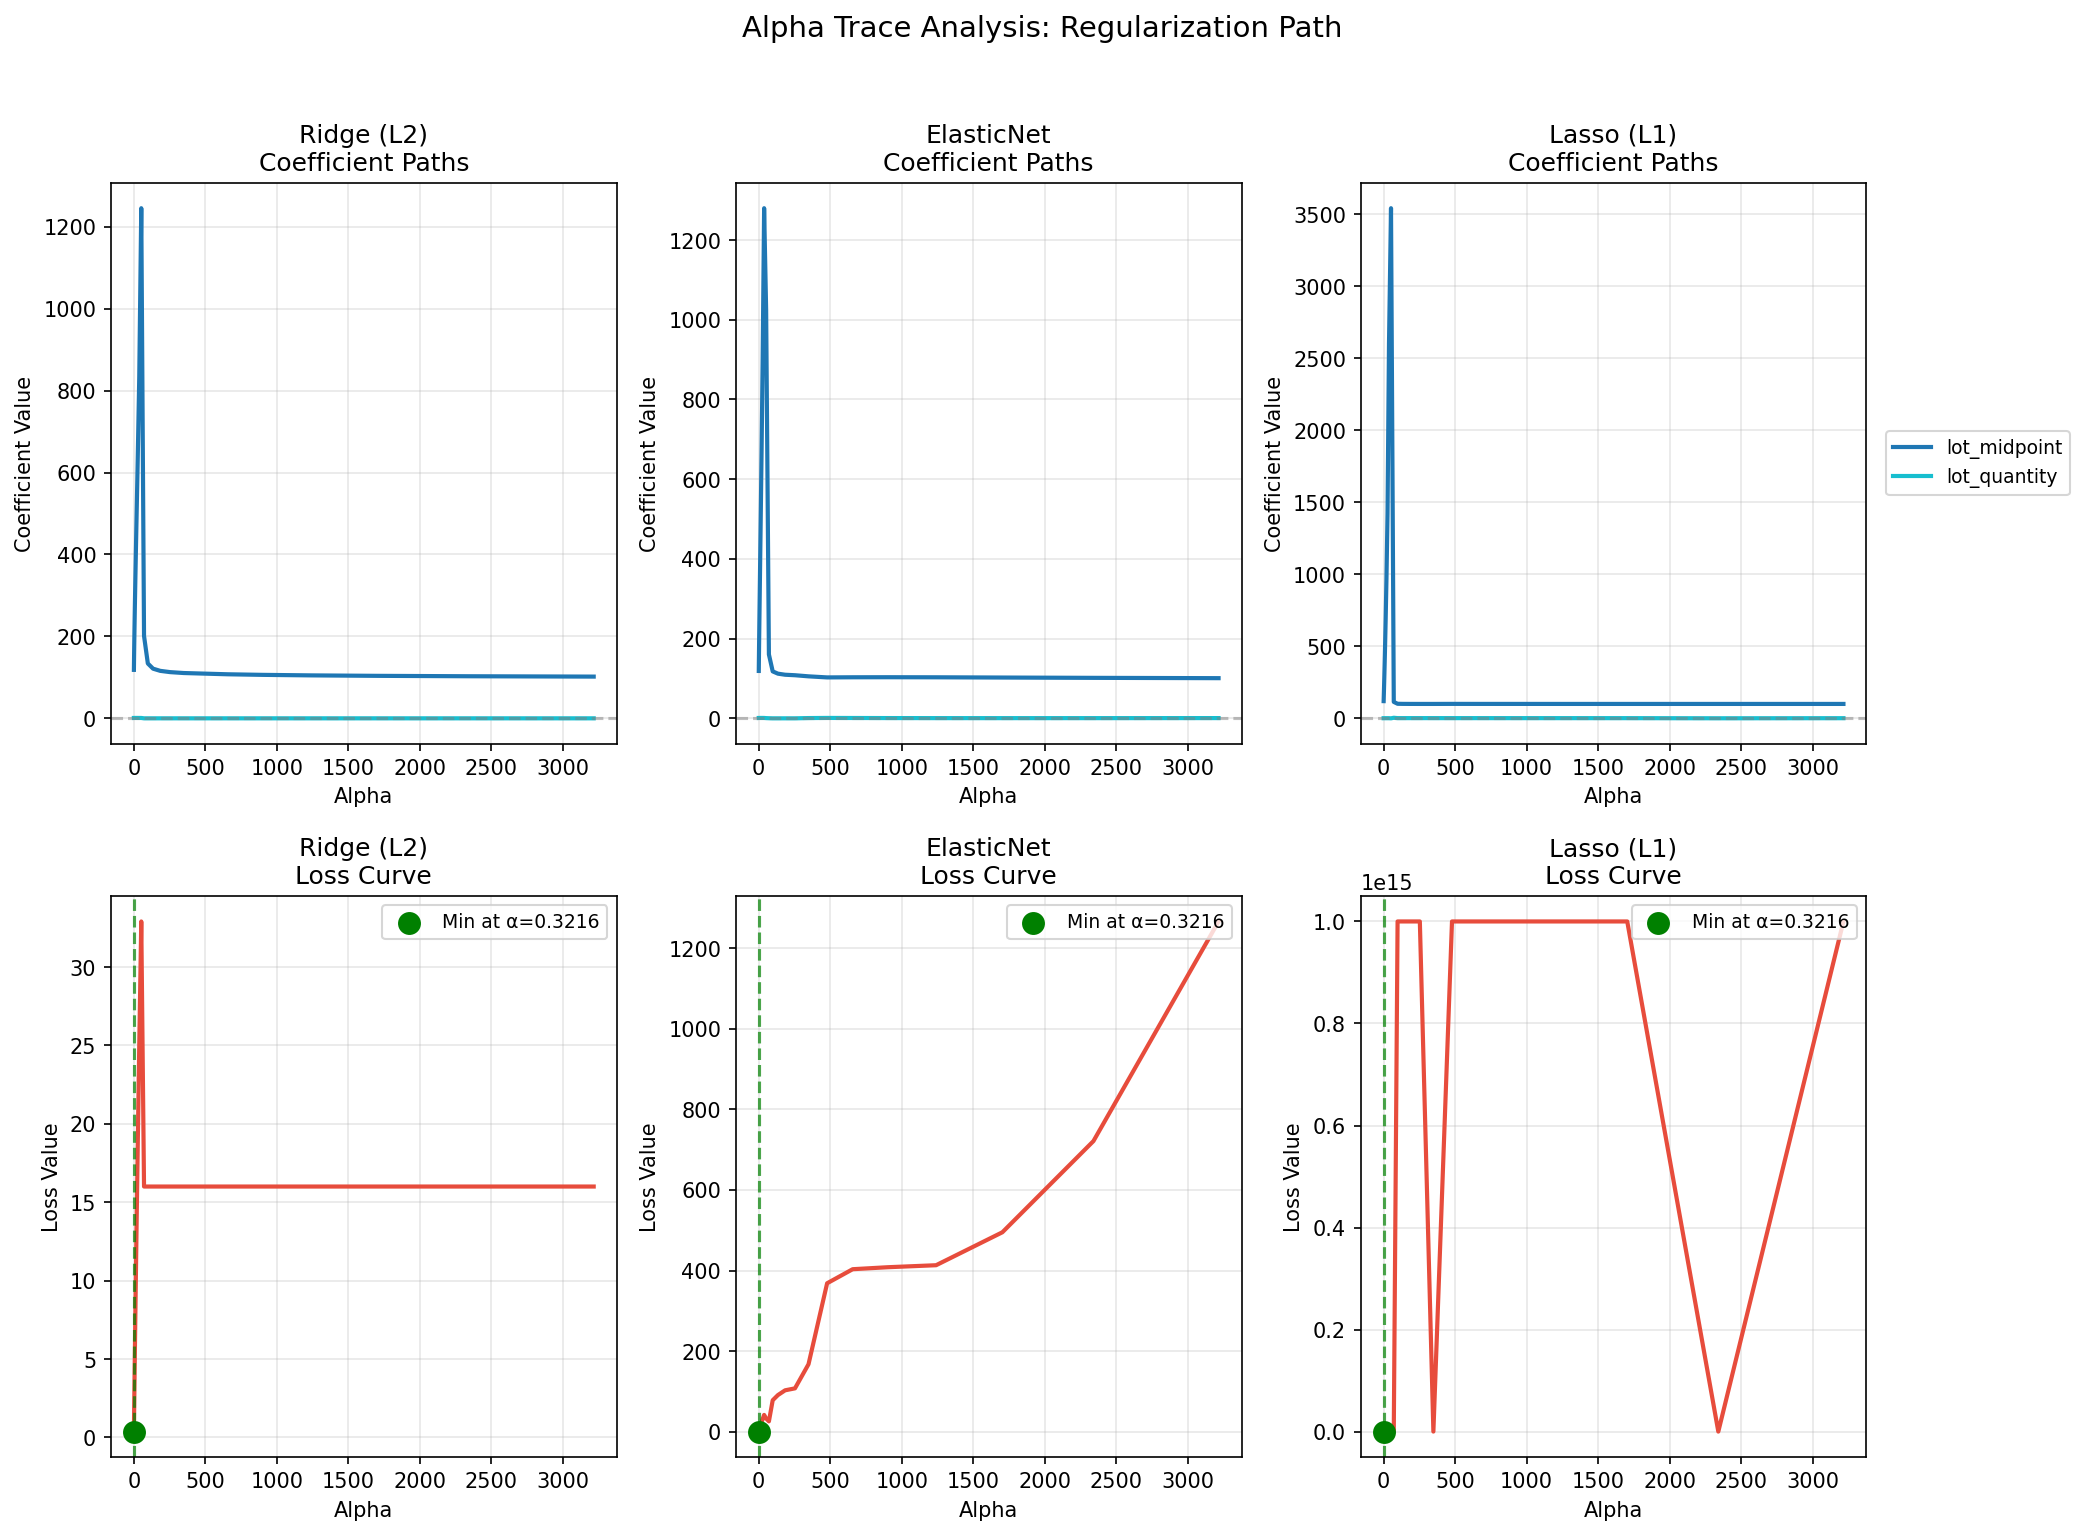

In [53]:
from IPython.display import HTML, display

# save report to variable using a file object
html_report = report.to_html()
# display report inline
display(HTML(html_report))

## Export PCReg Diagnostics Report

In [ ]:
report.to_html("scripts/demo/simple_usage_diagnostics.html")
#report.to_excel("scripts/demo/simple_usage_diagnostics.xlsx")
#report.to_pdf("scripts/demo/simple_usage_diagnostics.pdf")

## Generate Diagnostics for OLS Model

Generate diagnostics for the OLS model fitted in log space for comparison.

In [ ]:
report_ols = pcreg.ModelDiagnostics(ols_model, np.log(X), np.log(y))
report_ols_summary = report_ols.summary(bootstrap=True, n_bootstrap=100, include_alpha_trace=True)
report_ols_summary.plot_diagnostics()

## Export OLS Diagnostics Report

In [ ]:
report_ols_summary.to_html("scripts/demo/simple_usage_ols_diagnostics.html")